In [10]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
import sys
import math
import os
sys.path.append('/home/jgaud/data/PhD/Novelty Detection in Data Streams/streamndr-git/streamndr-private')

from dataclasses import dataclass

# Testing librairies
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, classification_report, fbeta_score, confusion_matrix
from itertools import repeat
from tqdm import tqdm
from pathos.pools import ProcessPool
from river.datasets import synth

from streamndr.model import Minas, ECSMinerWF, ECSMiner

import numpy as np
from aim import Run, Distribution

from streamndr.metrics import ConfusionMatrixNovelty, MNew, FNew, ErrRate, CER, TTD, TTC
from river.metrics import MacroF1, Rand, AdjustedRand, MutualInfo, AdjustedMutualInfo, VBeta, FowlkesMallows
from river import preprocessing
import time
from scipy.io import arff
import pandas as pd

from collections import deque, defaultdict

In [11]:
import aim
import pprint
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

aim_repo = '/home/jgaud/data/PhD/Novelty Detection in Data Streams/Extension/Revision/Aim Results/'
save_path = '/home/jgaud/data/PhD/Novelty Detection in Data Streams/Extension/Revision/Output/'
algorithms = ['ECSMinerWF', 'ECSMiner', 'Minas', "Echo"]

# Functions

In [12]:
def load_MOA(path):
    data = arff.loadarff(path)
    df = pd.DataFrame(data[0])
    
    for i, cl in enumerate(np.unique(df.iloc[:,-1])):
        df.iloc[:,-1].replace(cl, i, inplace=True)
    
    return df

def load_CSV(path):
    return pd.read_csv(path)


def generate_combinations(param_grid, baseline):
    combinations = []
    
    # Add single-value parameters to the baseline
    for param, values in param_grid.items():
        if len(values) == 1 and param not in baseline:
            baseline[param] = values[0]
    
    combinations.append(baseline.copy())
    
    # Generate combinations by changing one parameter at a time
    for param, values in param_grid.items():
        for value in values:
            if value != baseline.get(param, None):
                new_combination = baseline.copy()
                new_combination[param] = value
                combinations.append(new_combination)
    
    return combinations


def percentage_change(previous, current):
    if current == previous:
        return 0
    elif previous == 0:
        return float('inf')
    try:
        return ((current - previous) / abs(previous)) * 100.0
    except ZeroDivisionError:
        return float('inf')

def get_max_min_mean(data):   
    max_len = max(len(arr) for arr in data)
    max_values = []
    min_values = []
    avg_values = []
    
    for col_idx in range(max_len):
        # Create a temporary list to store values for this column
        column_data = []
        for arr in data:
          if col_idx < len(arr):
            column_data.append(arr[col_idx])
          else:
            # Use np.nan for missing values in shorter arrays
            column_data.append(np.nan)
          
        max_values.append(np.nanmax(column_data, axis=0))
        min_values.append(np.nanmin(column_data, axis=0))
        avg_values.append(np.nanmean(column_data, axis=0))
    
    return max_values, min_values, avg_values
    
def get_metrics(query, repo_path, selected_metrics=None):
    repo = aim.Repo(repo_path)  
    metrics = []

    for run_metrics_collection in repo.query_metrics(query).iter_runs():
        metric_values = {}
        for metric in run_metrics_collection.iter():
            metric_df = metric.dataframe()

            if (selected_metrics is None) or (metric.name in selected_metrics):
                if metric.name in ['inv_m_new', 'inv_f_new']:
                    metric_values[metric.name[4:]] = np.subtract(np.ones(shape=()),metric_df['value'].to_numpy())
                else:
                    metric_values[metric.name] = metric_df['value'].to_numpy()
                    
        if metric_values:
            metrics.append(metric_values)
    
    return metrics

def print_range_plots(dataset_name, condition, repo, metric_names, save_path=None):
    algorithms = ['ECSMinerWF', 'ECSMiner', 'Minas']
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for algo in algorithms:
        query = f'run.experiment == "{dataset_name}" and {condition} and "{algo}" in run.tags'

        try:
            metrics = get_metrics(query, repo, metric_names)
        
            # Splitting for save name
            parts = condition.split('==')
            dc_name = parts[0].strip().split('.')[-1]
            dc_value = parts[1].strip()
        
            for i, metric_name in enumerate(metric_names):
                values = [elem[metric_name] for elem in metrics]
    
                filename = f'{dataset}_{algo}_{dc_name}_{dc_value}_{metric_name}'
        
                max_values, min_values, mean_values = get_max_min_mean(values)
        
                x = ((np.arange(0, max(len(arr) for arr in values)) * 100 + 100) / 1000)
        
                fig, ax = plt.subplots()
        
                ax.plot(x, mean_values, color = colors[i])
                ax.fill_between(x, min_values, max_values, color = colors[i], alpha = 0.5)
                plt.xlabel('Samples (in thousands)', fontsize=15)
                plt.ylabel('Value', fontsize=15)
                plt.ylim(0,1)
                
                if save_path is not None:
                    plt.savefig(f'{save_path}Range_plots/eps/{filename}_plot.eps', format='eps', dpi=1200)
                    plt.savefig(f'{save_path}Range_plots/png/{filename}_plot.png', format='png', dpi=1200)
                                
                # #plt.show()
                # plt.clf()
        
                # data = [item for array in values for item in array]
                # plt.boxplot(data)
                
                # if save_path is not None:
                #     plt.savefig(f'{save_path}Range_plots/eps/{filename}_box.eps', format='eps', dpi=1200)
                #     plt.savefig(f'{save_path}Range_plots/png/{filename}_box.png', format='png', dpi=1200)
                
                # #plt.show()
            
        except Exception as e:
            print(str(e))
            print("Exception in query: " + query)

def flatten_dict(data):
    records = []

    for param_key, alg_dict in mean_perc_change.items():
        # Split the parameter key into parameter name and value
        if '=' in param_key:
            parameter, value = param_key.split('=')
            value = float(value)
        else:
            parameter = param_key
            value = None
        for algorithm, metrics in alg_dict.items():
            record = {
                'parameter': parameter,
                'value': value,
                'algorithm': algorithm
            }
            record.update(metrics)
            records.append(record)

    return records

# Dictionaries and Queries

In [13]:
datasets = [
    {
        "target": "Room_Occupancy_Count",
        "filename": "room_occupancy_bin.csv",
        "type": "bin",
    },
    {
        "target": "class",
        "filename": "rialto_bin.csv",
        "type": "bin",
    },
    {
        "target": "class",
        "filename": "powersupply_bin.csv",
        "type": "bin",
    },
    {
        "target": "Class",
        "filename": "gassensor_bin.csv",
        "type": "bin",
    },
    {
        "target": "label",
        "filename": "nursery_bin.csv",
        "type": "bin",
    },
    {"target": "Class", "filename": "connect4_bin.csv", "type": "bin",},
    {"target": "class", "filename": "sensit_bin.csv", "type": "bin",},
    {
        "target": "Class",
        "filename": "shuttle_bin.csv",
        "type": "bin",
    },
    {"target": "class", "filename": "randomtree_mc.csv", "type": "mc",},
    {"target": "class", "filename": "randomtree_bin.csv", "type": "bin",},
    {"target": "class", "filename": "randomrbf_mc.csv", "type": "mc",},
    {"target": "class", "filename": "randomrbf_bin.csv", "type": "bin",},
    {"target": "class", "filename": "sensit.csv", "type": "mc",},
    {"target": "Class", "filename": "connect4.csv", "type": "mc",},
    {"target": "Class", "filename": "adult.csv", "type": "bin",},
    {
        "target": "label",
        "filename": "nursery.csv",
        "type": "mc",
    },
    {
        "target": "Class",
        "filename": "creditcard.csv",
        "type": "bin",
    },
    {
        "target": "class",
        "filename": "elec.csv",
        "type": "bin",
    },
    {
        "target": "Class",
        "filename": "gassensor.arff",
        "type": "mc",
    },
    {
        "target": "class",
        "filename": "NOAA.arff",
        "type": "bin",
    },
    {
        "target": "class",
        "filename": "powersupply.arff",
        "type": "mc",
    },
    {
        "target": "class",
        "filename": "rialto.arff",
        "type": "mc",
    },
    {
        "target": "Room_Occupancy_Count",
        "filename": "room_occupancy.csv",
        "type": "mc",
    },
    {
        "target": "Class",
        "filename": "shuttle.csv",
        "type": "mc",
    },
]

concept_drift_datasets = [
    {
        "target": "class",
        "filename": "INSECTS-abrupt_balanced_norm.arff",
    },
    {
        "target": "class",
        "filename": "INSECTS-abrupt_imbalanced_norm.arff",
    },
    {
        "target": "class",
        "filename": "INSECTS-gradual_balanced_norm.arff",
    },
    {
        "target": "class",
        "filename": "INSECTS-gradual_imbalanced_norm.arff",
    },
    {
        "target": "class",
        "filename": "INSECTS-incremental-abrupt_balanced_norm.arff",
    },
    {
        "target": "class",
        "filename": "INSECTS-incremental-abrupt_imbalanced_norm.arff",
    },
    {
        "target": "class",
        "filename": "INSECTS-incremental_balanced_norm.arff",
    },
    {
        "target": "class",
        "filename": "INSECTS-incremental_imbalanced_norm.arff",
    },
    {
        "target": "class",
        "filename": "INSECTS-incremental-reoccurring_balanced_norm.arff",
    },
    {
        "target": "class",
        "filename": "INSECTS-incremental-reoccurring_imbalanced_norm.arff",
    },
]

In [14]:
baseline = 'run.ratio_wait_time_between_classes == 0 and run.sparsity == 1 and run.ratio_offline == 0.2 and run.ratio_known_classes == 0.2'

queries = {
    'ratio_wait_time=0.1': 'run.ratio_wait_time_between_classes == 0.1 and run.sparsity == 1 and run.ratio_offline == 0.2 and run.ratio_known_classes == 0.2',
    'ratio_wait_time=0.2': 'run.ratio_wait_time_between_classes == 0.2 and run.sparsity == 1 and run.ratio_offline == 0.2 and run.ratio_known_classes == 0.2',
    'ratio_offline=0.5': 'run.ratio_wait_time_between_classes == 0 and run.sparsity == 1 and run.ratio_offline == 0.5 and run.ratio_known_classes == 0.2',
    'ratio_offline=0.8': 'run.ratio_wait_time_between_classes == 0 and run.sparsity == 1 and run.ratio_offline == 0.8 and run.ratio_known_classes == 0.2',
    'ratio_known=0.5': 'run.ratio_wait_time_between_classes == 0 and run.sparsity == 1 and run.ratio_offline == 0.2 and run.ratio_known_classes == 0.5',
    'ratio_known=0.6': 'run.ratio_wait_time_between_classes == 0 and run.sparsity == 1 and run.ratio_offline == 0.2 and run.ratio_known_classes == 0.6',
    'sparsity=0.1': 'run.ratio_wait_time_between_classes == 0 and run.sparsity == 0.1 and run.ratio_offline == 0.2 and run.ratio_known_classes == 0.2',
    'sparsity=100': 'run.ratio_wait_time_between_classes == 0 and run.sparsity == 100 and run.ratio_offline == 0.2 and run.ratio_known_classes == 0.2',
    'sparsity=1000': 'run.ratio_wait_time_between_classes == 0 and run.sparsity == 1000 and run.ratio_offline == 0.2 and run.ratio_known_classes == 0.2'
}

baseline_numbers = {
    'ratio_wait_time' : 0,
    'ratio_offline': 0.2,
    'ratio_known': 0.2,
    'sparsity': 1,
}

# List of combinations

In [5]:
combinations = {}
combinations_no = {}
total = 0

param_grid = {
    'ratio_wait_time_between_classes': [0, 0.1, 0.2],
    'sparsity': [0.1, 1, 100, 1000],
    'ratio_offline': [0.2, 0.5, 0.8],
    'ratio_known_classes': [0.2, 0.5, 0.6],
    'random_state': [42],
}

baseline = {
    'ratio_wait_time_between_classes': 0,
    'sparsity': 1,
    'ratio_offline': 0.2,
    'ratio_known_classes': 0.2
}

mc_parameters = generate_combinations(param_grid, baseline)
param_grid['ratio_known_classes'] = [0.2]
binary_parameters = generate_combinations(param_grid, baseline)

for ds in datasets:
    filename = ds['filename']
    target = ds['target']
    
    if filename.endswith('.arff'):
        df = load_MOA(f'/home/jgaud/data/PhD/Novelty Detection in Data Streams/Data/prepared_data/{filename}')
    elif filename.endswith('.csv'):
        df = load_CSV(f'/home/jgaud/data/PhD/Novelty Detection in Data Streams/Data/prepared_data/{filename}')

    parameters = binary_parameters if len(np.unique(df[target])) == 2 else mc_parameters

    combinations[filename] = parameters
    combinations_no[filename] = len(parameters) * 4
    total += len(parameters) * 4

In [6]:
print(total)
pprint.pprint(combinations)
pprint.pprint(combinations_no)

1248
{'INSECTS-abrupt_balanced_norm.arff': [{'random_state': 42,
                                        'ratio_known_classes': 0.2,
                                        'ratio_offline': 0.2,
                                        'ratio_wait_time_between_classes': 0,
                                        'sparsity': 1},
                                       {'random_state': 42,
                                        'ratio_known_classes': 0.2,
                                        'ratio_offline': 0.2,
                                        'ratio_wait_time_between_classes': 0.1,
                                        'sparsity': 1},
                                       {'random_state': 42,
                                        'ratio_known_classes': 0.2,
                                        'ratio_offline': 0.2,
                                        'ratio_wait_time_between_classes': 0.2,
                                        'sparsity': 1},
                   

# Checking all runs are available

In [23]:
problematic_runs = []
repo = aim.Repo(aim_repo)

algorithms = ['Minas', 'Echo', 'ECSMiner', 'ECSMinerWF']
for ds in datasets:
    for alg in algorithms:
        filename = ds['filename']
        target = ds['target']
    
        
        query = f'run.experiment == "{filename}" and "{alg}" in run.tags'
        
        i = 0
        for run in repo.query_runs(query).iter_runs():
            i += 1

        if i != combinations_no[filename]/4:
            problematic_runs.append((filename, alg))

100%|████████████████████████████████████| 1356/1356 [00:00<00:00, 51314.80it/s]


In [24]:
problematic_runs

[]

In [113]:
def find_ds_index(filename):
    for i, ds in enumerate(datasets):
        if ds['filename'] == filename:
            return i

In [116]:
indexes_rerun = []
for filename, alg in problematic_runs:
    index = find_ds_index(filename)

    if alg == 'Minas':
        index = index * 3
    elif alg == 'ECSMiner':
        index = (index * 3) + 1
    elif alg == 'ECSMinerWF':
        index = (index * 3) + 2
    elif alg == 'Echo':
        index += 138

    indexes_rerun.append(index)

In [117]:
indexes_rerun

[45, 54, 66, 75, 167, 96]

# Datasets Table

In [148]:
binary_ds = []
mc_ds = []

for ds in datasets:
    filename = ds['filename']
    target = ds['target']
    
    if filename.endswith('.arff'):
        df = load_MOA(f'/home/jgaud/data/PhD/Novelty Detection in Data Streams/Data/prepared_data/{filename}')
    elif filename.endswith('.csv'):
        df = load_CSV(f'/home/jgaud/data/PhD/Novelty Detection in Data Streams/Data/prepared_data/{filename}')

    if len(np.unique(df[target])) == 2:
        binary_ds.append({'name': filename, 'no_features': df.shape[1]-1, 'no_samples': df.shape[0]})
    else:
        mc_ds.append({'name': filename, 'no_classes': len(np.unique(df[target])), 'no_features': df.shape[1]-1, 'no_samples': df.shape[0]})

In [149]:
pprint.pprint(binary_ds)
pprint.pprint(mc_ds)

[{'name': 'room_occupancy_bin.csv', 'no_features': 16, 'no_samples': 10129},
 {'name': 'rialto_bin.csv', 'no_features': 27, 'no_samples': 82250},
 {'name': 'powersupply_bin.csv', 'no_features': 2, 'no_samples': 29928},
 {'name': 'gassensor_bin.csv', 'no_features': 128, 'no_samples': 13910},
 {'name': 'nursery_bin.csv', 'no_features': 27, 'no_samples': 12960},
 {'name': 'connect4_bin.csv', 'no_features': 126, 'no_samples': 67557},
 {'name': 'sensit_bin.csv', 'no_features': 100, 'no_samples': 98528},
 {'name': 'shuttle_bin.csv', 'no_features': 8, 'no_samples': 58000},
 {'name': 'randomtree_bin.csv', 'no_features': 12, 'no_samples': 100000},
 {'name': 'randomrbf_bin.csv', 'no_features': 10, 'no_samples': 100000},
 {'name': 'adult.csv', 'no_features': 104, 'no_samples': 45222},
 {'name': 'creditcard.csv', 'no_features': 30, 'no_samples': 284807},
 {'name': 'elec.csv', 'no_features': 14, 'no_samples': 45312},
 {'name': 'NOAA.arff', 'no_features': 8, 'no_samples': 18159}]
[{'name': 'randomtr

In [151]:
len(binary_ds) + len(mc_ds)

34

# Extract Change Amount

In [7]:
perc_change = {
    'bin': {},
    'mc': {}
}

for ds in datasets:
    dataset_name = ds['filename']
    ds_type = ds['type']
    perc_change[ds_type][dataset_name] = {}
    
    for algo in algorithms:
        perc_change[ds_type][dataset_name][algo] = {}

        query = f'run.experiment == "{dataset_name}" and {baseline} and "{algo}" in run.tags'
        vals = get_metrics(query, aim_repo, ['adj_mut_info', 'inv_harm_mean'])

        vals_metric = [elem['adj_mut_info'] for elem in vals]
        vals_metric_harm = [elem['inv_harm_mean'] for elem in vals]

        if len(vals_metric) == 0 or len(vals_metric_harm) == 0:
            continue
            
        combined_array = np.concatenate(vals_metric)
        combined_array_harm = np.concatenate(vals_metric_harm)
        
        base_mean = np.mean(combined_array)
        base_median = np.median(combined_array)
        base_std = np.std(combined_array)

        base_mean_harm = np.mean(combined_array_harm)
        base_median_harm = np.median(combined_array_harm)
        base_std_harm = np.std(combined_array_harm)
        
        
        for characteristic in queries.keys():
            query = f'run.experiment == "{dataset_name}" and {queries[characteristic]} and "{algo}" in run.tags'
            vals = get_metrics(query, aim_repo, ['adj_mut_info', 'inv_harm_mean'])
            
            vals_metric = [elem['adj_mut_info'] for elem in vals]
            vals_metric_harm = [elem['inv_harm_mean'] for elem in vals]
            
            if len(vals_metric) == 0 or len(vals_metric_harm) == 0:
                continue
            
            combined_array = np.concatenate(vals_metric)
            combined_array_harm = np.concatenate(vals_metric_harm)
            perc_change[ds_type][dataset_name][algo][characteristic] = {}

            perc_change[ds_type][dataset_name][algo][characteristic]['per_mean'] = percentage_change(base_mean, np.mean(combined_array))
            perc_change[ds_type][dataset_name][algo][characteristic]['change_mean'] = np.mean(combined_array) - base_mean
            
            perc_change[ds_type][dataset_name][algo][characteristic]['per_median'] = percentage_change(base_median, np.median(combined_array))
            perc_change[ds_type][dataset_name][algo][characteristic]['change_median'] = np.median(combined_array) - base_median
            
            perc_change[ds_type][dataset_name][algo][characteristic]['per_std'] = percentage_change(base_std, np.std(combined_array))
            perc_change[ds_type][dataset_name][algo][characteristic]['change_std'] = np.std(combined_array) - base_std


            perc_change[ds_type][dataset_name][algo][characteristic]['per_mean_harm'] = percentage_change(base_mean_harm, np.mean(combined_array_harm))
            perc_change[ds_type][dataset_name][algo][characteristic]['change_mean_harm'] = np.mean(combined_array_harm) - base_mean_harm
            
            perc_change[ds_type][dataset_name][algo][characteristic]['per_median_harm'] = percentage_change(base_median_harm, np.median(combined_array_harm))
            perc_change[ds_type][dataset_name][algo][characteristic]['change_median_harm'] = np.median(combined_array_harm) - base_median_harm
            
            perc_change[ds_type][dataset_name][algo][characteristic]['per_std_harm'] = percentage_change(base_std_harm, np.std(combined_array_harm))
            perc_change[ds_type][dataset_name][algo][characteristic]['change_std_harm'] = np.std(combined_array_harm) - base_std_harm

100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1632.06it/s]


In [8]:
perc_change

{'bin': {'room_occupancy_bin.csv': {'ECSMinerWF': {'ratio_wait_time=0.1': {'per_mean': -84.3020691362718,
     'change_mean': -0.15941847013411248,
     'per_median': -94.68448678371583,
     'change_median': -0.13707767248109323,
     'per_std': -12.245503319535937,
     'change_std': -0.015426140618930287,
     'per_mean_harm': inf,
     'change_mean_harm': 0.26213823323541613,
     'per_median_harm': inf,
     'change_median_harm': 0.21121090687142963,
     'per_std_harm': inf,
     'change_std_harm': 0.18204748378851837},
    'ratio_wait_time=0.2': {'per_mean': -83.75436338903444,
     'change_mean': -0.15838273740296088,
     'per_median': -91.4044123910773,
     'change_median': -0.13232900690153757,
     'per_std': -14.902332489181939,
     'change_std': -0.018773052485431513,
     'per_mean_harm': inf,
     'change_mean_harm': 0.25179190752092867,
     'per_median_harm': inf,
     'change_median_harm': 0.20898872742921934,
     'per_std_harm': inf,
     'change_std_harm': 0.170

# Best and worst graphs

## Binary

In [9]:
minimum = {}
maximum = {}

bin_datasets = [ds for ds in datasets if ds['type'] == 'bin']

for characteristic in queries.keys():
    if characteristic.startswith('ratio_known'):
        continue

    minimum[characteristic] = {}
    maximum[characteristic] = {}
    
    for algo in algorithms:

        all_per_mean = []
        all_change_mean = []
        all_per_median = []
        all_change_median = []
        all_per_std = []
        all_change_std = []

        all_per_mean_harm = []
        all_change_mean_harm = []
        all_per_median_harm = []
        all_change_median_harm = []
        all_per_std_harm = []
        all_change_std_harm = []

        for ds in bin_datasets:
            ds_type = ds['type']
            dataset_name = ds['filename']
            
            if characteristic in perc_change[ds_type][dataset_name][algo] and perc_change[ds_type][dataset_name][algo][characteristic]:
                all_change_mean_harm.append(perc_change[ds_type][dataset_name][algo][characteristic]['change_mean_harm'])

        
        minimum[characteristic][algo] = (bin_datasets[np.argmin(all_change_mean_harm)]['filename'], np.min(all_change_mean_harm))
        maximum[characteristic][algo] = (bin_datasets[np.argmax(all_change_mean_harm)]['filename'], np.max(all_change_mean_harm))
        


grouped_min_values = defaultdict(dict)
grouped_max_values = defaultdict(dict)


# Grouping and finding the minimum values across related characteristics
for characteristic, algorithms in minimum.items():
    # Extract the prefix (e.g., 'ratio_wait_time', 'ratio_offline', etc.)
    prefix = characteristic.split('=')[0]
    
    # Find the minimum value for this characteristic
    min_algo = min(algorithms.items(), key=lambda x: x[1][1])
    
    # Update the grouped dictionary by comparing with existing minimum
    if prefix not in grouped_min_values or min_algo[1][1] < list(grouped_min_values[prefix].values())[0][1]:
        grouped_min_values[prefix] = {min_algo[0]: min_algo[1]}


# Grouping and finding the maximum values across related characteristics
for characteristic, algorithms in maximum.items():
    # Extract the prefix (e.g., 'ratio_wait_time', 'ratio_offline', etc.)
    prefix = characteristic.split('=')[0]
    
    # Find the maximum value for this characteristic
    max_algo = max(algorithms.items(), key=lambda x: x[1][1])
    
    # Update the grouped dictionary by comparing with existing maximum
    if prefix not in grouped_max_values or max_algo[1][1] > list(grouped_max_values[prefix].values())[0][1]:
        grouped_max_values[prefix] = {max_algo[0]: max_algo[1]}

grouped_min_values = dict(grouped_min_values)
grouped_max_values = dict(grouped_max_values)


In [121]:
pprint.pprint(grouped_min_values)

{'ratio_offline': {'ECSMiner': ('adult.csv', -0.5770966881677421)},
 'ratio_wait_time': {'ECSMiner': ('rialto_bin.csv', -0.4333675712632774)},
 'sparsity': {'Echo': ('gassensor_bin.csv', -0.32559376187912864)}}


In [122]:
pprint.pprint(grouped_max_values)

{'ratio_offline': {'Echo': ('room_occupancy_bin.csv', 0.7401827823222478)},
 'ratio_wait_time': {'ECSMinerWF': ('creditcard.csv', 0.577996482026797)},
 'sparsity': {'Echo': ('NOAA.arff', 0.5022937745603242)}}


100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1728.23it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Dataset: rialto_bin.csv; Algorithm: ECSMiner Characteristic: ratio_wait_time


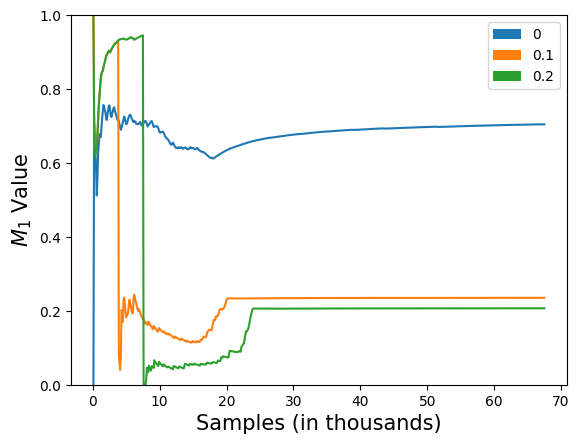

100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1396.76it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Dataset: creditcard.csv; Algorithm: ECSMinerWF Characteristic: ratio_wait_time


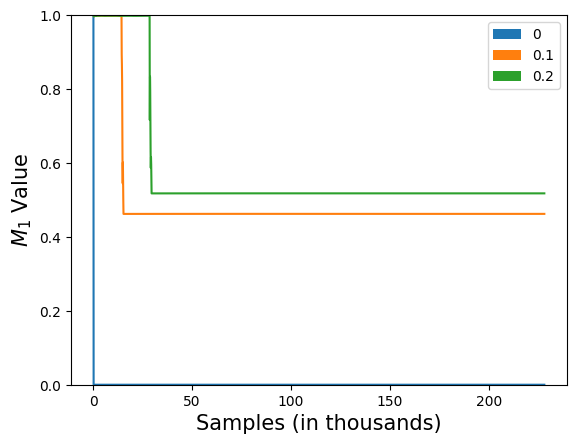

100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1836.50it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Dataset: adult.csv; Algorithm: ECSMiner Characteristic: ratio_offline


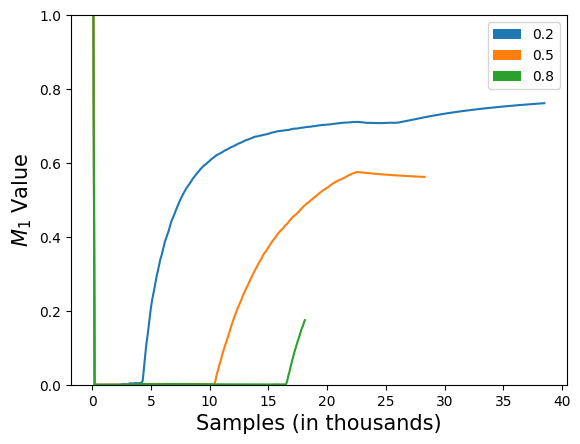

100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1889.64it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Dataset: room_occupancy_bin.csv; Algorithm: Echo Characteristic: ratio_offline


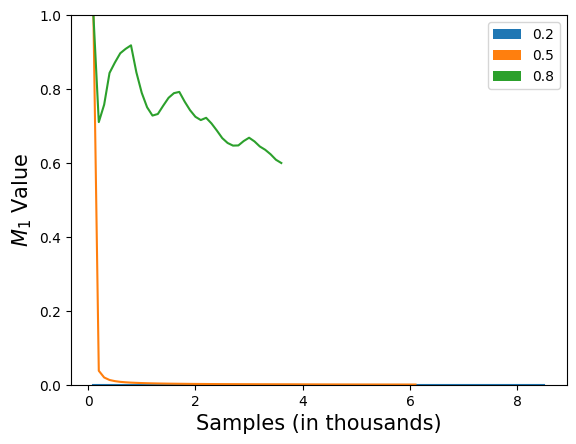

100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1871.97it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Dataset: gassensor_bin.csv; Algorithm: Echo Characteristic: sparsity


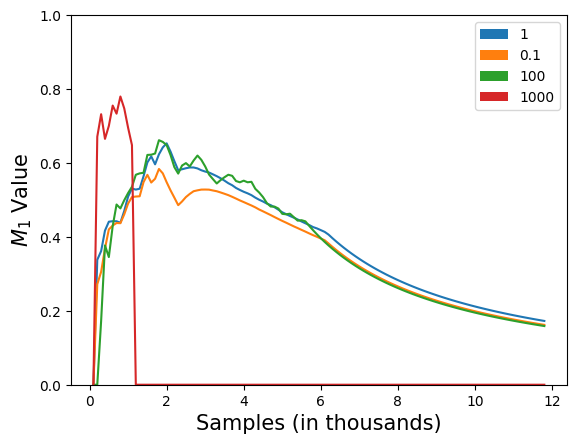

100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1561.07it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Dataset: NOAA.arff; Algorithm: Echo Characteristic: sparsity


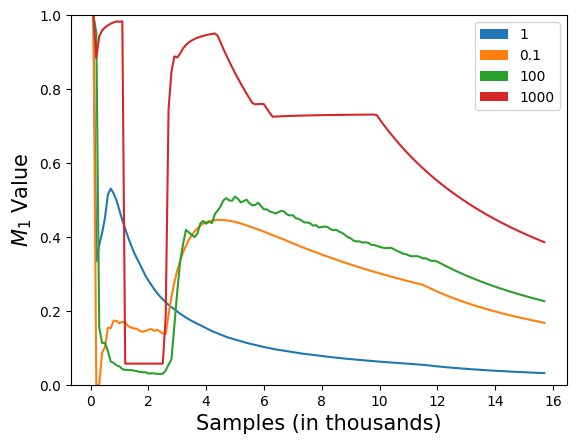

In [125]:
# Plot the graphs
metric_name = 'inv_harm_mean'

for charac in grouped_min_values:
    keys = [key for key in queries.keys() if key.startswith(charac)]
    
    # Minimum plot
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    fig, ax = plt.subplots()
    plt.xlabel('Samples (in thousands)', fontsize=15)
    plt.ylabel('$M_1$ Value', fontsize=15)

    plt.ylim(0,1)
    handles = []

    dataset_name = grouped_min_values[charac][list(grouped_min_values[charac])[0]][0]
    algo = list(grouped_min_values[charac])[0]

    for i in range(len(keys) + 1):
        dc_value = ''
        if i == 0:
            query = f'run.experiment == "{dataset_name}" and {baseline} and "{algo}" in run.tags'
            dc_value = baseline_numbers[charac]
        else:
            query = f'run.experiment == "{dataset_name}" \
                    and {queries[keys[i-1]]}\
                    and "{algo}" in run.tags'
            dc_value = keys[i-1].split('=')[1].strip()

        metrics = get_metrics(query, aim_repo, [metric_name])


        values = [elem[metric_name] for elem in metrics]

        if len(values) == 0:
            continue
    
        max_values, min_values, mean_values = get_max_min_mean(values)
    
        x = ((np.arange(0, max(len(arr) for arr in values)) * 100 + 100) / 1000)
        ax.plot(x, mean_values, color = colors[i])
        handles.append(Patch(facecolor=colors[i], label=dc_value))

    plt.legend(handles=handles)#, loc='upper center', bbox_to_anchor=(0.45, 1.15), ncol=5, fontsize=15)

    if save_path is not None:
        plt.savefig(f'{save_path}Graphs/min_max/{charac}_min_{dataset_name}_{algo}_plot_m1.eps', format='eps', dpi=1200)
        plt.savefig(f'{save_path}Graphs/min_max/{charac}_min_{dataset_name}_{algo}_plot_m1.png', format='png', dpi=1200)
    
    print(f"Dataset: {dataset_name}; Algorithm: {algo} Characteristic: {charac}")
    plt.show()


    # Maximum plot
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    fig, ax = plt.subplots()
    plt.xlabel('Samples (in thousands)', fontsize=15)
    plt.ylabel('$M_1$ Value', fontsize=15)

    plt.ylim(0,1)
    handles = []

    dataset_name = grouped_max_values[charac][list(grouped_max_values[charac])[0]][0]
    algo = list(grouped_max_values[charac])[0]

    for i in range(len(keys) + 1):
        dc_value = ''
        if i == 0:
            query = f'run.experiment == "{dataset_name}" and {baseline} and "{algo}" in run.tags'
            dc_value = baseline_numbers[charac]
        else:
            query = f'run.experiment == "{dataset_name}" \
                    and {queries[keys[i-1]]}\
                    and "{algo}" in run.tags'
            dc_value = keys[i-1].split('=')[1].strip()

        metrics = get_metrics(query, aim_repo, [metric_name])


        values = [elem[metric_name] for elem in metrics]

        if len(values) == 0:
            continue
    
        max_values, min_values, mean_values = get_max_min_mean(values)
    
        x = ((np.arange(0, max(len(arr) for arr in values)) * 100 + 100) / 1000)
        ax.plot(x, mean_values, color = colors[i])
        handles.append(Patch(facecolor=colors[i], label=dc_value))

    plt.legend(handles=handles)#, loc='upper center', bbox_to_anchor=(0.45, 1.15), ncol=5, fontsize=15)

    if save_path is not None:
        plt.savefig(f'{save_path}Graphs/min_max/{charac}_max_{dataset_name}_{algo}_plot_m1.eps', format='eps', dpi=1200)
        plt.savefig(f'{save_path}Graphs/min_max/{charac}_max_{dataset_name}_{algo}_plot_m1.png', format='png', dpi=1200)
    
    print(f"Dataset: {dataset_name}; Algorithm: {algo} Characteristic: {charac}")
    plt.show()

## Multi-Class

In [10]:
minimum = {}
maximum = {}
mc_datasets = [ds for ds in datasets if ds['type'] == 'mc']

for characteristic in queries.keys():

    minimum[characteristic] = {}
    maximum[characteristic] = {}
    
    for algo in algorithms:

        all_per_mean = []
        all_change_mean = []
        all_per_median = []
        all_change_median = []
        all_per_std = []
        all_change_std = []

        all_per_mean_harm = []
        all_change_mean_harm = []
        all_per_median_harm = []
        all_change_median_harm = []
        all_per_std_harm = []
        all_change_std_harm = []

        for ds in mc_datasets:
            ds_type = ds['type']
            dataset_name = ds['filename']
            
            if characteristic in perc_change[ds_type][dataset_name][algo] and perc_change[ds_type][dataset_name][algo][characteristic]:
                all_change_mean.append(perc_change[ds_type][dataset_name][algo][characteristic]['change_mean'])

        
        minimum[characteristic][algo] = (mc_datasets[np.argmin(all_change_mean)]['filename'], np.min(all_change_mean))
        maximum[characteristic][algo] = (mc_datasets[np.argmax(all_change_mean)]['filename'], np.max(all_change_mean))
        


grouped_min_values = defaultdict(dict)
grouped_max_values = defaultdict(dict)

# Grouping and finding the minimum values across related characteristics
for characteristic, algorithms in minimum.items():
    # Extract the prefix (e.g., 'ratio_wait_time', 'ratio_offline', etc.)
    prefix = characteristic.split('=')[0]
    
    # Find the minimum value for this characteristic
    min_algo = min(algorithms.items(), key=lambda x: x[1][1])
    
    # Update the grouped dictionary by comparing with existing minimum
    if prefix not in grouped_min_values or min_algo[1][1] < list(grouped_min_values[prefix].values())[0][1]:
        grouped_min_values[prefix] = {min_algo[0]: min_algo[1]}


# Grouping and finding the maximum values across related characteristics
for characteristic, algorithms in maximum.items():
    # Extract the prefix (e.g., 'ratio_wait_time', 'ratio_offline', etc.)
    prefix = characteristic.split('=')[0]
    
    # Find the maximum value for this characteristic
    max_algo = max(algorithms.items(), key=lambda x: x[1][1])
    
    # Update the grouped dictionary by comparing with existing maximum
    if prefix not in grouped_max_values or max_algo[1][1] > list(grouped_max_values[prefix].values())[0][1]:
        grouped_max_values[prefix] = {max_algo[0]: max_algo[1]}

grouped_min_values = dict(grouped_min_values)
grouped_max_values = dict(grouped_max_values)

In [11]:
pprint.pprint(grouped_min_values)

{'ratio_known': {'ECSMiner': ('nursery.csv', -0.12527842228142386)},
 'ratio_offline': {'ECSMiner': ('shuttle.csv', -0.3070998680649535)},
 'ratio_wait_time': {'Minas': ('sensit.csv', -0.10200134498929868)},
 'sparsity': {'ECSMiner': ('nursery.csv', -0.25432276231334267)}}


In [12]:
pprint.pprint(grouped_max_values)

{'ratio_known': {'Echo': ('shuttle.csv', 0.7632708782843657)},
 'ratio_offline': {'Echo': ('shuttle.csv', 0.4992117914604336)},
 'ratio_wait_time': {'Echo': ('gassensor.arff', 0.09268060996263172)},
 'sparsity': {'Minas': ('shuttle.csv', 0.20473910668127793)}}


100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1605.80it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Dataset: sensit.csv; Algorithm: Minas Characteristic: ratio_wait_time


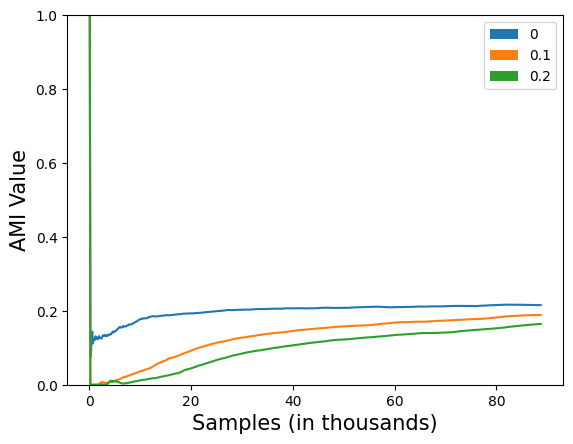

100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1820.73it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Dataset: gassensor.arff; Algorithm: Echo Characteristic: ratio_wait_time


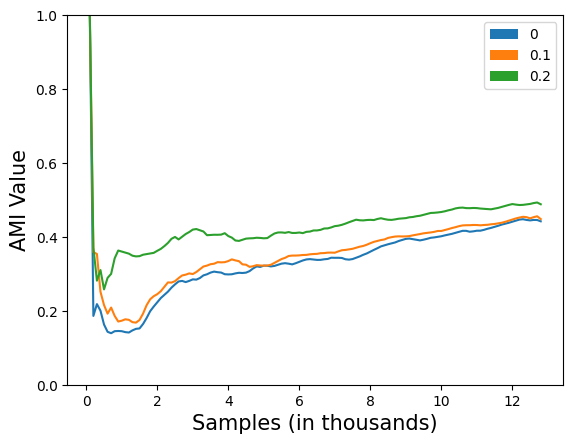

100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1787.14it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Dataset: shuttle.csv; Algorithm: ECSMiner Characteristic: ratio_offline


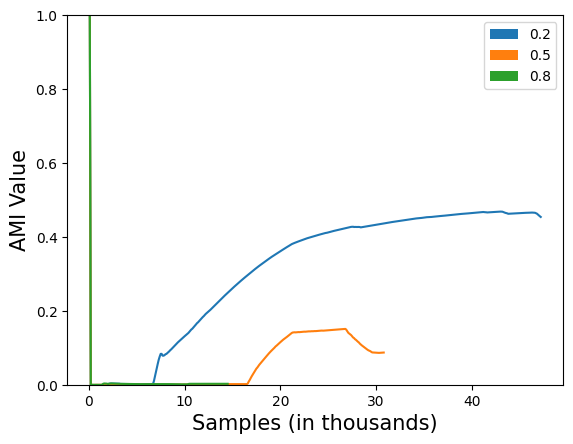

100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1803.74it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Dataset: shuttle.csv; Algorithm: Echo Characteristic: ratio_offline


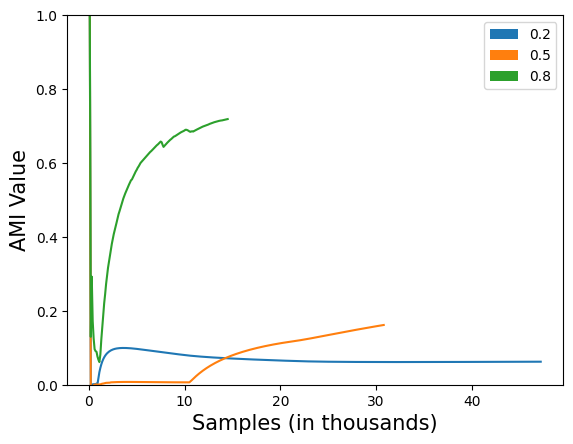

100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1816.94it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Dataset: nursery.csv; Algorithm: ECSMiner Characteristic: ratio_known


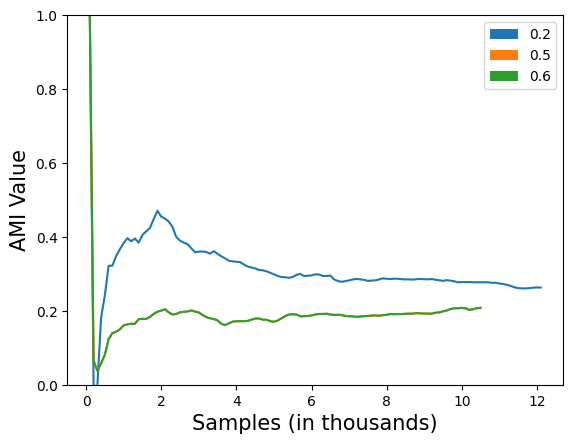

100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1694.12it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Dataset: shuttle.csv; Algorithm: Echo Characteristic: ratio_known


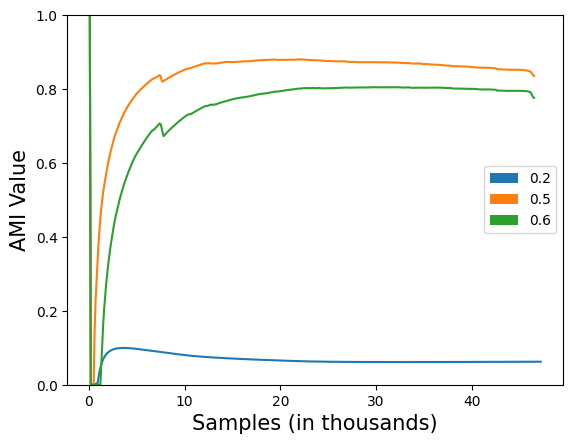

100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1834.01it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Dataset: nursery.csv; Algorithm: ECSMiner Characteristic: sparsity


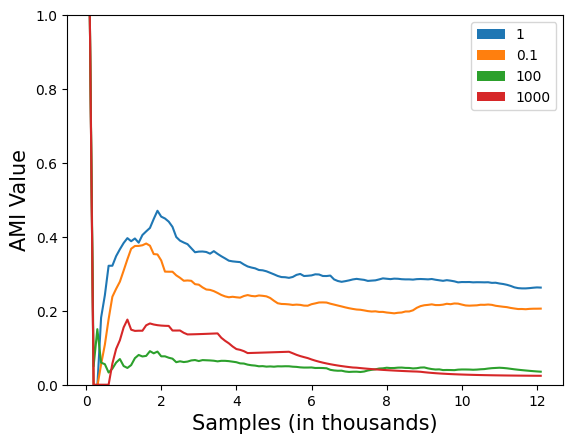

100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1514.24it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Dataset: shuttle.csv; Algorithm: Minas Characteristic: sparsity


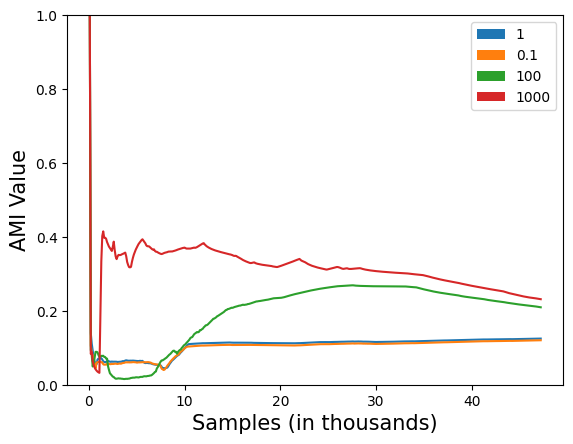

In [13]:
# Plot the graphs
metric_name = 'adj_mut_info'

for charac in grouped_min_values:
    keys = [key for key in queries.keys() if key.startswith(charac)]
    
    # Minimum plot
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    fig, ax = plt.subplots()
    plt.xlabel('Samples (in thousands)', fontsize=15)
    plt.ylabel('AMI Value', fontsize=15)

    plt.ylim(0,1)
    handles = []

    dataset_name = grouped_min_values[charac][list(grouped_min_values[charac])[0]][0]
    algo = list(grouped_min_values[charac])[0]

    for i in range(len(keys) + 1):
        dc_value = ''
        if i == 0:
            query = f'run.experiment == "{dataset_name}" and {baseline} and "{algo}" in run.tags'
            dc_value = baseline_numbers[charac]
        else:
            query = f'run.experiment == "{dataset_name}" \
                    and {queries[keys[i-1]]}\
                    and "{algo}" in run.tags'
            dc_value = keys[i-1].split('=')[1].strip()

        metrics = get_metrics(query, aim_repo, [metric_name])


        values = [elem[metric_name] for elem in metrics]

        if len(values) == 0:
            continue
    
        max_values, min_values, mean_values = get_max_min_mean(values)
    
        x = ((np.arange(0, max(len(arr) for arr in values)) * 100 + 100) / 1000)
        ax.plot(x, mean_values, color = colors[i])
        handles.append(Patch(facecolor=colors[i], label=dc_value))

    plt.legend(handles=handles)#, loc='upper center', bbox_to_anchor=(0.45, 1.15), ncol=5, fontsize=15)

    if save_path is not None:
        plt.savefig(f'{save_path}Graphs/min_max/{charac}_min_{dataset_name}_{algo}_plot_ami.eps', format='eps', dpi=1200)
        plt.savefig(f'{save_path}Graphs/min_max/{charac}_min_{dataset_name}_{algo}_plot_ami.png', format='png', dpi=1200)
    
    print(f"Dataset: {dataset_name}; Algorithm: {algo} Characteristic: {charac}")
    plt.show()


    # Maximum plot
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    fig, ax = plt.subplots()
    plt.xlabel('Samples (in thousands)', fontsize=15)
    plt.ylabel('AMI Value', fontsize=15)

    plt.ylim(0,1)
    handles = []

    dataset_name = grouped_max_values[charac][list(grouped_max_values[charac])[0]][0]
    algo = list(grouped_max_values[charac])[0]

    for i in range(len(keys) + 1):
        dc_value = ''
        if i == 0:
            query = f'run.experiment == "{dataset_name}" and {baseline} and "{algo}" in run.tags'
            dc_value = baseline_numbers[charac]
        else:
            query = f'run.experiment == "{dataset_name}" \
                    and {queries[keys[i-1]]}\
                    and "{algo}" in run.tags'
            dc_value = keys[i-1].split('=')[1].strip()

        metrics = get_metrics(query, aim_repo, [metric_name])


        values = [elem[metric_name] for elem in metrics]

        if len(values) == 0:
            continue
    
        max_values, min_values, mean_values = get_max_min_mean(values)
    
        x = ((np.arange(0, max(len(arr) for arr in values)) * 100 + 100) / 1000)
        ax.plot(x, mean_values, color = colors[i])
        handles.append(Patch(facecolor=colors[i], label=dc_value))

    plt.legend(handles=handles)#, loc='upper center', bbox_to_anchor=(0.45, 1.15), ncol=5, fontsize=15)

    if save_path is not None:
        plt.savefig(f'{save_path}Graphs/min_max/{charac}_max_{dataset_name}_{algo}_plot_ami.eps', format='eps', dpi=1200)
        plt.savefig(f'{save_path}Graphs/min_max/{charac}_max_{dataset_name}_{algo}_plot_ami.png', format='png', dpi=1200)
    
    print(f"Dataset: {dataset_name}; Algorithm: {algo} Characteristic: {charac}")
    plt.show()

# Table

## Binary

In [58]:
mean_perc_change = {}

for characteristic in queries.keys():
    if characteristic.startswith('ratio_known'):
        continue
        
    mean_perc_change[characteristic] = {}

    for algo in algorithms:
        mean_perc_change[characteristic][algo] = {}

        all_per_mean = []
        all_change_mean = []
        all_per_median = []
        all_change_median = []
        all_per_std = []
        all_change_std = []

        all_per_mean_harm = []
        all_change_mean_harm = []
        all_per_median_harm = []
        all_change_median_harm = []
        all_per_std_harm = []
        all_change_std_harm = []

        for ds in datasets:
            ds_type = ds['type']
            dataset_name = ds['filename']

            if ds_type == 'mc':
                continue
            
            if characteristic in perc_change[ds_type][dataset_name][algo] and perc_change[ds_type][dataset_name][algo][characteristic]:
                all_per_mean.append(perc_change[ds_type][dataset_name][algo][characteristic]['per_mean'])
                all_change_mean.append(perc_change[ds_type][dataset_name][algo][characteristic]['change_mean'])
    
                all_per_median.append(perc_change[ds_type][dataset_name][algo][characteristic]['per_median'])
                all_change_median.append(perc_change[ds_type][dataset_name][algo][characteristic]['change_median'])
    
                all_per_std.append(perc_change[ds_type][dataset_name][algo][characteristic]['per_std'])
                all_change_std.append(perc_change[ds_type][dataset_name][algo][characteristic]['change_std'])


                all_per_mean_harm.append(perc_change[ds_type][dataset_name][algo][characteristic]['per_mean_harm'])
                all_change_mean_harm.append(perc_change[ds_type][dataset_name][algo][characteristic]['change_mean_harm'])
    
                all_per_median_harm.append(perc_change[ds_type][dataset_name][algo][characteristic]['per_median_harm'])
                all_change_median_harm.append(perc_change[ds_type][dataset_name][algo][characteristic]['change_median_harm'])
    
                all_per_std_harm.append(perc_change[ds_type][dataset_name][algo][characteristic]['per_std_harm'])
                all_change_std_harm.append(perc_change[ds_type][dataset_name][algo][characteristic]['change_std_harm'])

        mean_perc_change[characteristic][algo]['change_mean_harm'] = np.mean(all_change_mean_harm)
        mean_perc_change[characteristic][algo]['change_median_harm'] = np.mean(all_change_median_harm)
        mean_perc_change[characteristic][algo]['change_std_harm'] = np.mean(all_change_std_harm)
        

In [59]:
mean_perc_change

{'ratio_wait_time=0.1': {'ECSMinerWF': {'change_mean_harm': 0.10478953510253002,
   'change_median_harm': 0.06666548556694306,
   'change_std_harm': 0.11827550266993449},
  'ECSMiner': {'change_mean_harm': 0.00473852627662723,
   'change_median_harm': -0.00433363936602548,
   'change_std_harm': 0.033373879387885275},
  'Minas': {'change_mean_harm': 0.09135525692699457,
   'change_median_harm': 0.074072065940829,
   'change_std_harm': 0.04475468449025306},
  'Echo': {'change_mean_harm': 0.10311626089993309,
   'change_median_harm': 0.07406984245476166,
   'change_std_harm': 0.07167655167909234}},
 'ratio_wait_time=0.2': {'ECSMinerWF': {'change_mean_harm': 0.13725691973301063,
   'change_median_harm': 0.07725489883016964,
   'change_std_harm': 0.15495408681534267},
  'ECSMiner': {'change_mean_harm': 0.011033926055289103,
   'change_median_harm': -0.00740846554805403,
   'change_std_harm': 0.056778462145093724},
  'Minas': {'change_mean_harm': 0.12361546712282492,
   'change_median_harm':

In [62]:
df = pd.DataFrame(flatten_dict(mean_perc_change))
df

,parameter,value,algorithm,change_mean_harm,change_median_harm,change_std_harm
0,ratio_wait_time,0.1,ECSMinerWF,0.104790,0.066665,0.118276
1,ratio_wait_time,0.1,ECSMiner,0.004739,-0.004334,0.033374
2,ratio_wait_time,0.1,Minas,0.091355,0.074072,0.044755
3,ratio_wait_time,0.1,Echo,0.103116,0.074070,0.071677
4,ratio_wait_time,0.2,ECSMinerWF,0.137257,0.077255,0.154954
5,ratio_wait_time,0.2,ECSMiner,0.011034,-0.007408,0.056778
6,ratio_wait_time,0.2,Minas,0.123615,0.102057,0.053947
7,ratio_wait_time,0.2,Echo,0.102520,0.084420,0.058877
8,ratio_offline,0.5,ECSMinerWF,-0.087599,-0.092746,0.000854
9,ratio_offline,0.5,ECSMiner,-0.110475,-0.081162,0.045168


In [63]:
df.to_excel(save_path + 'binary_table.xlsx', index=False)

## Multi-Class

In [64]:
mean_perc_change = {}

for characteristic in queries.keys():
    mean_perc_change[characteristic] = {}

    for algo in algorithms:
        mean_perc_change[characteristic][algo] = {}

        all_per_mean = []
        all_change_mean = []
        all_per_median = []
        all_change_median = []
        all_per_std = []
        all_change_std = []

        all_per_mean_harm = []
        all_change_mean_harm = []
        all_per_median_harm = []
        all_change_median_harm = []
        all_per_std_harm = []
        all_change_std_harm = []

        for ds in datasets:
            ds_type = ds['type']
            dataset_name = ds['filename']
            if ds_type == 'bin':
                continue
            
            if characteristic in perc_change[ds_type][dataset_name][algo] and perc_change[ds_type][dataset_name][algo][characteristic]:
                all_per_mean.append(perc_change[ds_type][dataset_name][algo][characteristic]['per_mean'])
                all_change_mean.append(perc_change[ds_type][dataset_name][algo][characteristic]['change_mean'])
    
                all_per_median.append(perc_change[ds_type][dataset_name][algo][characteristic]['per_median'])
                all_change_median.append(perc_change[ds_type][dataset_name][algo][characteristic]['change_median'])
    
                all_per_std.append(perc_change[ds_type][dataset_name][algo][characteristic]['per_std'])
                all_change_std.append(perc_change[ds_type][dataset_name][algo][characteristic]['change_std'])


                all_per_mean_harm.append(perc_change[ds_type][dataset_name][algo][characteristic]['per_mean_harm'])
                all_change_mean_harm.append(perc_change[ds_type][dataset_name][algo][characteristic]['change_mean_harm'])
    
                all_per_median_harm.append(perc_change[ds_type][dataset_name][algo][characteristic]['per_median_harm'])
                all_change_median_harm.append(perc_change[ds_type][dataset_name][algo][characteristic]['change_median_harm'])
    
                all_per_std_harm.append(perc_change[ds_type][dataset_name][algo][characteristic]['per_std_harm'])
                all_change_std_harm.append(perc_change[ds_type][dataset_name][algo][characteristic]['change_std_harm'])

        mean_perc_change[characteristic][algo]['change_mean'] = np.mean(all_change_mean)
        mean_perc_change[characteristic][algo]['change_median'] = np.mean(all_change_median)
        mean_perc_change[characteristic][algo]['change_std'] = np.mean(all_change_std)

        mean_perc_change[characteristic][algo]['change_mean_harm'] = np.mean(all_change_mean_harm)
        mean_perc_change[characteristic][algo]['change_median_harm'] = np.mean(all_change_median_harm)
        mean_perc_change[characteristic][algo]['change_std_harm'] = np.mean(all_change_std_harm)
        

In [65]:
mean_perc_change

{'ratio_wait_time=0.1': {'ECSMinerWF': {'change_mean': -0.0010038922556648068,
   'change_median': 0.0019526188767602151,
   'change_std': 0.005942551230196215,
   'change_mean_harm': 0.0383440161584354,
   'change_median_harm': 0.022949729391342412,
   'change_std_harm': 0.05618644924239506},
  'ECSMiner': {'change_mean': -0.004910725057392269,
   'change_median': -0.007404846647041233,
   'change_std': -9.857453314791875e-06,
   'change_mean_harm': -0.026751335704666722,
   'change_median_harm': -0.03333760848659257,
   'change_std_harm': -0.0004172890187080475},
  'Minas': {'change_mean': -0.000836858334134366,
   'change_median': -0.0006491709831087919,
   'change_std': 0.008072239224165069,
   'change_mean_harm': 0.06109430792667636,
   'change_median_harm': 0.03458188945144039,
   'change_std_harm': 0.04693371075577414},
  'Echo': {'change_mean': 0.006209868846051357,
   'change_median': 0.0008995405027115245,
   'change_std': 0.02455084850869243,
   'change_mean_harm': 0.0719887

In [67]:
df = pd.DataFrame(flatten_dict(mean_perc_change))
df

,parameter,value,algorithm,change_mean,change_median,change_std,change_mean_harm,change_median_harm,change_std_harm
0,ratio_wait_time,0.1,ECSMinerWF,-0.001004,0.001953,0.005943,0.038344,0.022950,0.056186
1,ratio_wait_time,0.1,ECSMiner,-0.004911,-0.007405,-0.000010,-0.026751,-0.033338,-0.000417
2,ratio_wait_time,0.1,Minas,-0.000837,-0.000649,0.008072,0.061094,0.034582,0.046934
3,ratio_wait_time,0.1,Echo,0.006210,0.000900,0.024551,0.071989,0.048951,0.049087
4,ratio_wait_time,0.2,ECSMinerWF,-0.002323,0.000801,0.006870,0.069180,0.040570,0.086682
5,ratio_wait_time,0.2,ECSMiner,-0.014273,-0.016467,0.002820,-0.026240,-0.033240,0.006773
6,ratio_wait_time,0.2,Minas,-0.005238,-0.005845,0.013322,0.110485,0.080716,0.066404
7,ratio_wait_time,0.2,Echo,0.019553,0.012872,0.021253,0.098715,0.076908,0.047953
8,ratio_offline,0.5,ECSMinerWF,0.014528,0.016611,0.005490,-0.057364,-0.057136,0.000388
9,ratio_offline,0.5,ECSMiner,-0.035689,-0.045861,-0.000242,-0.064100,-0.027695,0.063523


In [68]:
df.to_excel(save_path + 'mc_table.xlsx', index=False)

# Correlation Graph

In [10]:
mc_datasets = [ds['filename'] for ds in datasets if ds['type'] == 'mc']

In [12]:
metrics = get_metrics(f'run.experiment in {mc_datasets}', aim_repo, ['adj_mut_info', 'cer'])

100%|███████████████████████████████████████| 1356/1356 [00:38<00:00, 35.27it/s]


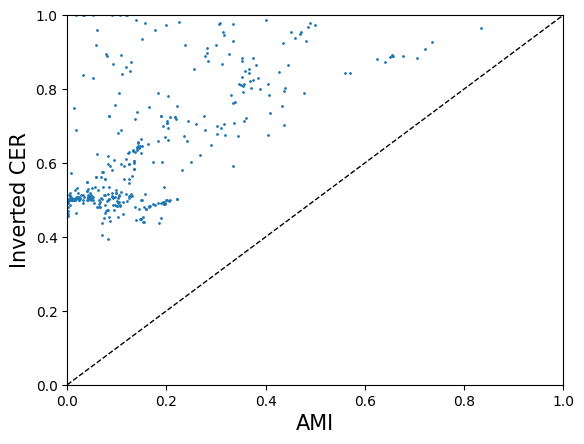

In [14]:
x_ami = []
y_inv_cer = []

for i in range(len(metrics)):
    x_ami.append(np.mean(metrics[i]['adj_mut_info']))
    y_inv_cer.append(np.mean(1-metrics[i]['cer']))

fig, ax = plt.subplots()
plt.scatter(x_ami, y_inv_cer, s=1)
plt.xlabel('AMI', fontsize=15)
plt.ylabel('Inverted CER', fontsize=15)
plt.ylim(0, 1)
plt.xlim(0, 1)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='black',linewidth=1)
plt.savefig(f'{save_path}Graphs/correlation.eps', format='eps', dpi=1200)
plt.show()

# Temporal Metrics

In [31]:
metric_names = []
for i in range(99):
    metric_names.append(f'ttc_{i}')
    metric_names.append(f'ttd_{i}')
    
time_metric_change = {}

for ds in datasets:
    dataset_name = ds['filename']
    ds_type = ds['type']
    time_metric_change[dataset_name] = {}
    
    for algo in algorithms:
        base = {}
        time_metric_change[dataset_name][algo] = {}

        query = f'run.experiment == "{dataset_name}" and {baseline} and "{algo}" in run.tags'
        vals = get_metrics(query, aim_repo, metric_names)

        if len(vals) == 0:
            continue

        for metric in vals[0]:
            if metric.startswith("ttc"):
                base[metric] = np.mean(vals[0][metric])
            else:
                base[metric] = vals[0][metric][0]
        
        
        for characteristic in queries.keys():
            if characteristic.startswith("ratio_known"):
                continue
                
            time_metric_change[dataset_name][algo][characteristic] = {}
            
            query = f'run.experiment == "{dataset_name}" and {queries[characteristic]} and "{algo}" in run.tags'
            vals = get_metrics(query, aim_repo, metric_names)

            if len(vals) == 0:
                continue

            for metric in vals[0]:
                if metric in base:
                    if metric.startswith("ttc"):
                        time_metric_change[dataset_name][algo][characteristic][metric] = np.mean(vals[0][metric]) - base[metric]
                    else:
                        if base[metric] != - 1:
                            time_metric_change[dataset_name][algo][characteristic][metric] = np.mean(vals[0][metric][0]) - base[metric]
                        
                    

100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1624.05it/s]


In [32]:
min_ttd_value = None
max_ttd_value = None
min_ttd_info = None
max_ttd_info = None

min_ttc_value = None
max_ttc_value = None
min_ttc_info = None
max_ttc_info = None

for dataset, algorithms in time_metric_change.items():
    for algorithm, characteristics in algorithms.items():
        for characteristic, metrics in characteristics.items():
            for metric_name, value in metrics.items():
                if metric_name.startswith('ttd_'):
                    # Process ttd metrics
                    if isinstance(value, (int, float)):
                        if (min_ttd_value is None) or (value < min_ttd_value):
                            min_ttd_value = value
                            min_ttd_info = (dataset, algorithm, characteristic, metric_name)
                        if (max_ttd_value is None) or (value > max_ttd_value):
                            max_ttd_value = value
                            max_ttd_info = (dataset, algorithm, characteristic, metric_name)
                elif metric_name.startswith('ttc_'):
                    # Process ttc metrics
                    if isinstance(value, (int, float)):
                        if (min_ttc_value is None) or (value < min_ttc_value):
                            min_ttc_value = value
                            min_ttc_info = (dataset, algorithm, characteristic, metric_name)
                        if (max_ttc_value is None) or (value > max_ttc_value):
                            max_ttc_value = value
                            max_ttc_info = (dataset, algorithm, characteristic, metric_name)

# Results
print("\nMaximum ttd_X metric:")
print(f"Value: {max_ttd_value}")
print(f"Dataset: {max_ttd_info[0]}")
print(f"Algorithm: {max_ttd_info[1]}")
print(f"Characteristic: {max_ttd_info[2]}")
print(f"Metric: {max_ttd_info[3]}")

print("\nMaximum ttc_X metric:")
print(f"Value: {max_ttc_value}")
print(f"Dataset: {max_ttc_info[0]}")
print(f"Algorithm: {max_ttc_info[1]}")
print(f"Characteristic: {max_ttc_info[2]}")
print(f"Metric: {max_ttc_info[3]}")



Maximum ttd_X metric:
Value: 10909.0
Dataset: sensit_bin.csv
Algorithm: ECSMiner
Characteristic: ratio_offline=0.8
Metric: ttd_0

Maximum ttc_X metric:
Value: 675.8157631147542
Dataset: nursery.csv
Algorithm: Minas
Characteristic: sparsity=1000
Metric: ttc_0


## TTC plots

100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1642.13it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Dataset: sensit_bin.csv; Algorithm: ECSMiner Characteristic: ratio_offline


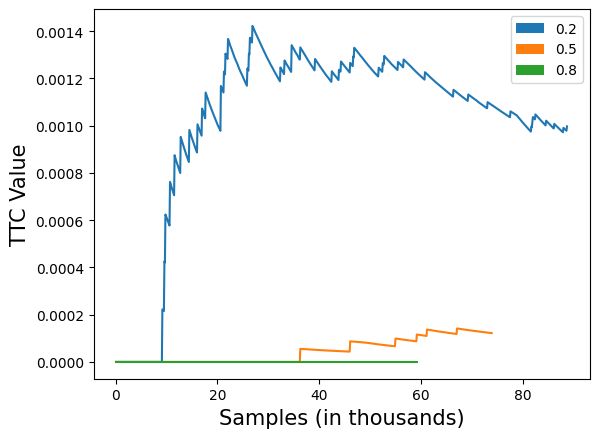

In [33]:
# Maximum TTD plot
dataset_name = max_ttd_info[0]
algo = max_ttd_info[1]
charac = max_ttd_info[2].split('=')[0]
metric_name = 'ttc_0'

keys = [key for key in queries.keys() if key.startswith(charac)]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots()
plt.xlabel('Samples (in thousands)', fontsize=15)
plt.ylabel('TTC Value', fontsize=15)

handles = []

for i in range(len(keys) + 1):
    dc_value = ''
    if i == 0:
        query = f'run.experiment == "{dataset_name}" and {baseline} and "{algo}" in run.tags'
        dc_value = baseline_numbers[charac]
    else:
        query = f'run.experiment == "{dataset_name}" \
                and {queries[keys[i-1]]}\
                and "{algo}" in run.tags'
        dc_value = keys[i-1].split('=')[1].strip()

    metrics = get_metrics(query, aim_repo, [metric_name])


    values = [elem[metric_name] for elem in metrics]

    if len(values) == 0:
        continue

    max_values, min_values, mean_values = get_max_min_mean(values)

    x = ((np.arange(0, max(len(arr) for arr in values)) * 100 + 100) / 1000)
    ax.plot(x, mean_values, color = colors[i])
    handles.append(Patch(facecolor=colors[i], label=dc_value))

plt.legend(handles=handles)#, loc='upper center', bbox_to_anchor=(0.45, 1.15), ncol=5, fontsize=15)

if save_path is not None:
    plt.savefig(f'{save_path}Graphs/min_max/{charac}_max_{dataset_name}_{algo}_plot_{metric_name}.eps', format='eps', dpi=1200)
    plt.savefig(f'{save_path}Graphs/min_max/{charac}_max_{dataset_name}_{algo}_plot_{metric_name}.png', format='png', dpi=1200)

print(f"Dataset: {dataset_name}; Algorithm: {algo} Characteristic: {charac}")
plt.show()

100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1647.59it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Dataset: sensit_bin.csv; Algorithm: ECSMiner Characteristic: ratio_offline


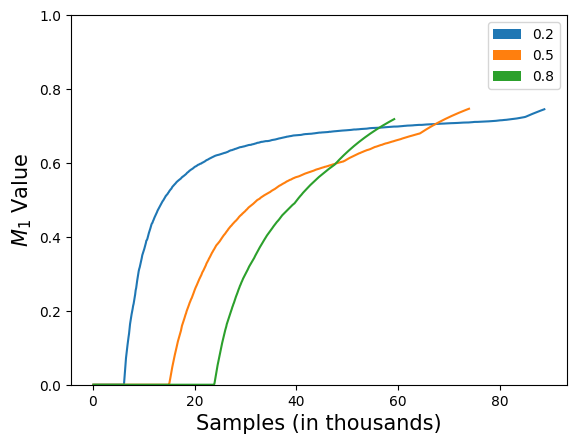

In [34]:
dataset_name = max_ttd_info[0]
algo = max_ttd_info[1]
charac = max_ttd_info[2].split('=')[0]
metric_name = 'inv_harm_mean'

keys = [key for key in queries.keys() if key.startswith(charac)]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots()
plt.xlabel('Samples (in thousands)', fontsize=15)
plt.ylabel('$M_1$ Value', fontsize=15)
plt.ylim(0,1)

handles = []

for i in range(len(keys) + 1):
    dc_value = ''
    if i == 0:
        query = f'run.experiment == "{dataset_name}" and {baseline} and "{algo}" in run.tags'
        dc_value = baseline_numbers[charac]
    else:
        query = f'run.experiment == "{dataset_name}" \
                and {queries[keys[i-1]]}\
                and "{algo}" in run.tags'
        dc_value = keys[i-1].split('=')[1].strip()

    metrics = get_metrics(query, aim_repo, [metric_name])


    values = [elem[metric_name] for elem in metrics]

    if len(values) == 0:
        continue

    max_values, min_values, mean_values = get_max_min_mean(values)

    x = ((np.arange(0, max(len(arr) for arr in values)) * 100 + 100) / 1000)
    ax.plot(x, mean_values, color = colors[i])
    handles.append(Patch(facecolor=colors[i], label=dc_value))

plt.legend(handles=handles)#, loc='upper center', bbox_to_anchor=(0.45, 1.15), ncol=5, fontsize=15)

if save_path is not None:
    plt.savefig(f'{save_path}Graphs/min_max/{charac}_max_{dataset_name}_{algo}_plot_m_1_time.eps', format='eps', dpi=1200)
    plt.savefig(f'{save_path}Graphs/min_max/{charac}_max_{dataset_name}_{algo}_plot_m_1_time.png', format='png', dpi=1200)

print(f"Dataset: {dataset_name}; Algorithm: {algo} Characteristic: {charac}")
plt.show()

100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1762.76it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Dataset: nursery.csv; Algorithm: Minas Characteristic: sparsity


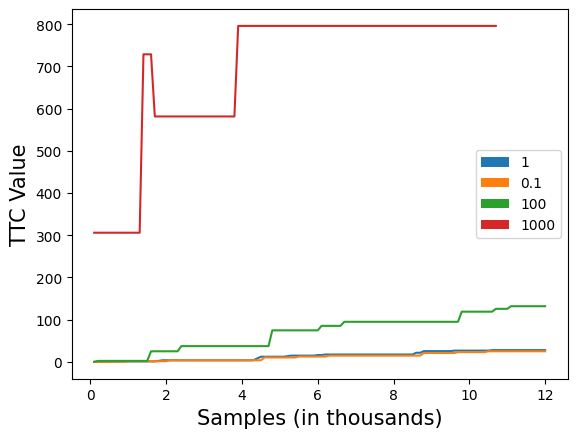

In [27]:
# Maximum TTC plot
dataset_name = max_ttc_info[0]
algo = max_ttc_info[1]
charac = max_ttc_info[2].split('=')[0]
metric_name = max_ttc_info[3]

keys = [key for key in queries.keys() if key.startswith(charac)]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots()
plt.xlabel('Samples (in thousands)', fontsize=15)
plt.ylabel('TTC Value', fontsize=15)

handles = []

for i in range(len(keys) + 1):
    dc_value = ''
    if i == 0:
        query = f'run.experiment == "{dataset_name}" and {baseline} and "{algo}" in run.tags'
        dc_value = baseline_numbers[charac]
    else:
        query = f'run.experiment == "{dataset_name}" \
                and {queries[keys[i-1]]}\
                and "{algo}" in run.tags'
        dc_value = keys[i-1].split('=')[1].strip()

    metrics = get_metrics(query, aim_repo, [metric_name])


    values = [elem[metric_name] for elem in metrics]

    if len(values) == 0:
        continue

    max_values, min_values, mean_values = get_max_min_mean(values)

    x = ((np.arange(0, max(len(arr) for arr in values)) * 100 + 100) / 1000)
    ax.plot(x, mean_values, color = colors[i])
    handles.append(Patch(facecolor=colors[i], label=dc_value))

plt.legend(handles=handles)#, loc='upper center', bbox_to_anchor=(0.45, 1.15), ncol=5, fontsize=15)

if save_path is not None:
    plt.savefig(f'{save_path}Graphs/min_max/{charac}_max_{dataset_name}_{algo}_plot_{metric_name}.eps', format='eps', dpi=1200)
    plt.savefig(f'{save_path}Graphs/min_max/{charac}_max_{dataset_name}_{algo}_plot_{metric_name}.png', format='png', dpi=1200)

print(f"Dataset: {dataset_name}; Algorithm: {algo} Characteristic: {charac}")
plt.show()

100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1749.31it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Dataset: nursery.csv; Algorithm: Minas Characteristic: sparsity


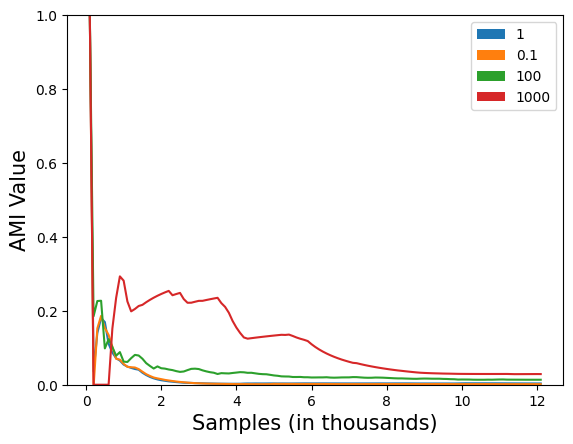

In [30]:
dataset_name = max_ttc_info[0]
algo = max_ttc_info[1]
charac = max_ttc_info[2].split('=')[0]
metric_name = 'adj_mut_info'

keys = [key for key in queries.keys() if key.startswith(charac)]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots()
plt.xlabel('Samples (in thousands)', fontsize=15)
plt.ylabel('AMI Value', fontsize=15)
plt.ylim(0,1)

handles = []

for i in range(len(keys) + 1):
    dc_value = ''
    if i == 0:
        query = f'run.experiment == "{dataset_name}" and {baseline} and "{algo}" in run.tags'
        dc_value = baseline_numbers[charac]
    else:
        query = f'run.experiment == "{dataset_name}" \
                and {queries[keys[i-1]]}\
                and "{algo}" in run.tags'
        dc_value = keys[i-1].split('=')[1].strip()

    metrics = get_metrics(query, aim_repo, [metric_name])


    values = [elem[metric_name] for elem in metrics]

    if len(values) == 0:
        continue

    max_values, min_values, mean_values = get_max_min_mean(values)

    x = ((np.arange(0, max(len(arr) for arr in values)) * 100 + 100) / 1000)
    ax.plot(x, mean_values, color = colors[i])
    handles.append(Patch(facecolor=colors[i], label=dc_value))

plt.legend(handles=handles)#, loc='upper center', bbox_to_anchor=(0.45, 1.15), ncol=5, fontsize=15)

if save_path is not None:
    plt.savefig(f'{save_path}Graphs/min_max/{charac}_max_{dataset_name}_{algo}_plot_ami_time.eps', format='eps', dpi=1200)
    plt.savefig(f'{save_path}Graphs/min_max/{charac}_max_{dataset_name}_{algo}_plot_ami_time.png', format='png', dpi=1200)

print(f"Dataset: {dataset_name}; Algorithm: {algo} Characteristic: {charac}")
plt.show()